In [1]:
import json
from graph import ScheduleGraph
import pandas as pd
import numpy as np
import time
import copy

## 1. Prepare planning data

In [2]:
PLANING_PATH = 'data/planning.json'
f = open(PLANING_PATH, 'rb')
planning_data = json.load(f)

In [3]:
schedule_graph = ScheduleGraph(planning_id = planning_data['planning_id'])

In [4]:

schedule_data = planning_data['schedule']

In [5]:
# Load data schedule to ScheduleGraph
schedule_graph.load_schedule(schedule_data)

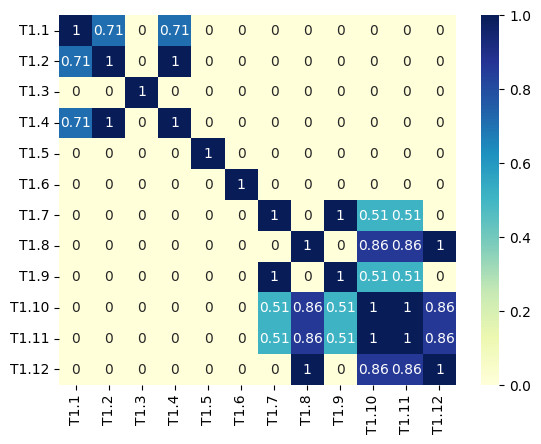

<Figure size 1000x600 with 0 Axes>

In [6]:
# visualize task similality
schedule_graph.task_similarity_heatmap()

## 2. Load workforce

In [7]:
WORKFORCE_DATA_PATH = '/Users/pvm/Desktop/Đồ Án/data/workforces.json'
f = open(WORKFORCE_DATA_PATH, 'rb')
workforce_data = json.load(f)
schedule_graph.load_workforce(workforce_data = workforce_data)

# 4. Load Contraints

## NSGA2 helper

### 1. Initial population

In [8]:
def initial_popular(graph: ScheduleGraph, population_size: int):
    num_of_tasks = len(graph.task_list)
    population_list = np.empty((population_size, num_of_tasks), dtype=int)
    workforce_list = graph.workforce_list
    for i in range(population_size):
        for j in range(num_of_tasks):
            task = graph.task_list[j]
            available_workforce = graph.nodes[task]['available_workforce']
            available_workforce_indices = [index for index, value in enumerate(available_workforce.values()) if value]
            selected_index = np.random.choice(available_workforce_indices)
            selected_workforce = list(available_workforce.keys())[selected_index]
            population_list[i, j] = workforce_list.index(selected_workforce)

    return population_list

In [9]:
def crossover(population_list, num_task: int, population_size: int):
    cosssover_offspring = [] # danh sách con cái được tạo ra từ crossover
    # Lấy ngẫu nhiên 2 parents
    random_parent_indices = list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    for m in range(int(population_size/2)):
        parent_1= population_list[random_parent_indices[2*m]][:]

        parent_2= population_list[random_parent_indices[2*m+1]][:]
        child_1=parent_1[:]
        child_2=parent_2[:]
        
        # Lấy ngẫu nhiên 2 đoạn bất kỳ trong parent 1 chuyển cho parent 2
        cutpoint=list(np.random.choice(num_task, 2, replace=False))
        cutpoint.sort()
        child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
        child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
        
        cosssover_offspring.extend((child_1,child_2))
    return cosssover_offspring

In [10]:
def mutation(offspring_list, num_task: int, muation_selection_rate: float, muation_rate: float):
    num_mutation_jobs = round(num_task*muation_selection_rate)
    # Thực hiện đảo ngược 1 gen
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if muation_rate <= mutation_prob:
            # chooses the position to mutation
            m_chg=list(np.random.choice(num_task, num_mutation_jobs, replace=False))
            # save the value which is on the first mutation position
            
            t_value_last=offspring_list[m][m_chg[0]] 
            
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last

    return offspring_list

In [11]:
def non_dominated_sorting(population_size, chroms_obj_record):
    solution, non_dominate = {}, {}
    front, rank = {}, {}
    front[0] = []

    for p in range(population_size*2):
        solution[p] = []
        non_dominate[p] = 0
        for q in range(population_size * 2):
            is_dominated = False
            dominated_count = 0
            for obj in range(len(chroms_obj_record[p])):
               
                if chroms_obj_record[p][obj] > chroms_obj_record[q][obj]:
                    dominated_count += 1
                elif chroms_obj_record[p][obj] < chroms_obj_record[q][obj]:
                    is_dominated = True
                    break
               
            if is_dominated:
                if q not in solution[p]:
                    solution[p].append(q)

            elif not is_dominated and dominated_count == len(chroms_obj_record[p]):
                non_dominate[p] = non_dominate[p] + 1

    
        if non_dominate[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    
    
    i = 0
    while front[i] != []:
        Q = []
        for p in front[i]:
            for q in solution[p]:
                non_dominate[q] = non_dominate[q] - 1
                if non_dominate[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i = i + 1
        front[i] = Q

    del front[len(front) - 1]
    return front


def calculate_crowding_distance(front,chroms_obj_record):
    distance={m:0 for m in front}
    for o in range(len(chroms_obj_record[0])):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])
            
    return distance  

In [12]:

def selection(front, population_size: int, chroms_obj_record: list, total_chromosome: list):   
    N=0
    new_pop=[]
    print("start selection.....")
    while N < population_size:
        for i in range(len(front)):
            
            if N > population_size:
                # Compare on each front after append solution with higher distance to new_pop
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break   
                    if chroms_obj_record[j][1] > 0:
                        new_pop.append(j)       
                        N += 1       
                break
            else:
                for index in front[i]:
                    if chroms_obj_record[index][1] > 0: 
                        
                        new_pop.append(index)
                        N += 1
    
    print("Done selection.....")
    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])
    
    print(f"population_list: {len(population_list)}")
    print(f"new_pop: {len(new_pop)}")
    return population_list, new_pop

In [13]:
def compute_fitness(graph_copy: ScheduleGraph, total_chromosome: list, population_size: int):
    chroms_obj_record={} 
    for m in range(population_size*2):
        results = graph_copy.apply_assignment(assignment_list = total_chromosome[m])
        chroms_obj_record[m]=[1/results['overall_cost'], results['overall_skill_similarity'], results['overall_task_similarity'], 1/results['completed_time']]
    return chroms_obj_record

## NSGA2 Experiment

### Setup parammeters

In [14]:
# Initial Resouces
POPULATION_SIZE = 1000

# Initial NSGA2 params
NUMBER_ITERATION = 10
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.4
MUTATION_SELECTION_RATE = 0.4


### Initial population

In [15]:
population_list = initial_popular(graph = schedule_graph, population_size=POPULATION_SIZE)

In [16]:
population_list

array([[2, 5, 5, ..., 2, 2, 2],
       [2, 0, 5, ..., 2, 2, 2],
       [2, 0, 5, ..., 2, 2, 2],
       ...,
       [2, 2, 5, ..., 2, 2, 2],
       [2, 5, 5, ..., 2, 2, 2],
       [2, 5, 5, ..., 2, 2, 2]])

### Running

In [17]:
from tqdm import tqdm

best_list,best_obj=[],[]
for n in tqdm(range(NUMBER_ITERATION)):   
    schedule_graph_copy = copy.deepcopy(schedule_graph)

    parent_list=copy.deepcopy(population_list)
    offspring_list=[] # danh sách children
    
    # Crossover
    crossover_offspring = crossover(
        population_list = population_list,
        num_task = len(schedule_graph_copy.task_list),
        population_size = POPULATION_SIZE
    )
    offspring_list.extend(crossover_offspring)

    
    # Mutation
    offspring_list = mutation(
        offspring_list = offspring_list,
        num_task = len(schedule_graph_copy.task_list),
        muation_selection_rate = MUTATION_SELECTION_RATE,
        muation_rate = MUTATION_RATE
    )
    
   
    # Selection
    total_chromosome= copy.deepcopy(np.concatenate((parent_list, np.array(offspring_list))))
    chroms_obj_record = compute_fitness(
        total_chromosome = total_chromosome,
        graph_copy = schedule_graph_copy,
        population_size = POPULATION_SIZE
     )
   
    front=non_dominated_sorting(POPULATION_SIZE,chroms_obj_record)

    population_list,new_pop=selection(
        front = front,
        population_size = POPULATION_SIZE,
        chroms_obj_record = chroms_obj_record,
        total_chromosome = total_chromosome)
    
    new_pop_obj=[chroms_obj_record[k] for k in new_pop] 
   
    # Comparison
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    
    else:            
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
        start_time = time.time()
        
        now_best_front=non_dominated_sorting(
            population_size = POPULATION_SIZE,
            chroms_obj_record = total_obj)
        
        best_list,best_pop=selection(
            front = now_best_front,
            population_size = POPULATION_SIZE,
            chroms_obj_record = total_obj,
            total_chromosome = total_list)

        best_obj=[total_obj[k] for k in best_pop]

 10%|█         | 1/10 [00:26<04:02, 26.96s/it]

start selection.....
Done selection.....
population_list: 1440
new_pop: 1440
start selection.....
Done selection.....
population_list: 1681
new_pop: 1681


 20%|██        | 2/10 [01:18<05:29, 41.21s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1817
new_pop: 1817


 30%|███       | 3/10 [02:13<05:34, 47.75s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1901
new_pop: 1901


 40%|████      | 4/10 [03:06<04:59, 49.84s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1941
new_pop: 1941


 50%|█████     | 5/10 [04:00<04:17, 51.41s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1966
new_pop: 1966


 60%|██████    | 6/10 [04:55<03:29, 52.45s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1979
new_pop: 1979


 70%|███████   | 7/10 [05:48<02:37, 52.61s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1984
new_pop: 1984


 80%|████████  | 8/10 [06:41<01:45, 52.75s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1991
new_pop: 1991


 90%|█████████ | 9/10 [07:32<00:52, 52.12s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000
start selection.....
Done selection.....
population_list: 1994
new_pop: 1994


100%|██████████| 10/10 [08:23<00:00, 50.35s/it]

start selection.....
Done selection.....
population_list: 2000
new_pop: 2000


### Evaluate

In [26]:
print('-----Results -----------------------------')
print("One chromosome(1x100)=",best_list[0])
print("best_obj=",best_obj[0])
print("------------------------------------------")
print('The elapsed time:%s'% (time.time() - start_time))

-----Results -----------------------------
One chromosome(1x100)= [2 2 5 1 6 4 1 2 2 2 2 2]
best_obj= [0.0008130081300813008, 7.818149594380012, 34.999999999999986, 0.023255813953488372]
------------------------------------------
The elapsed time:70.86278104782104


In [27]:
import pandas as pd
df = pd.DataFrame(best_obj, columns = ['cost', 'assigned_level', 'quality', 'completed_time'])
df['solution'] = best_list

In [28]:
df.describe()

,cost,assigned_level,quality,completed_time
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.000851,7.776806,34.601000,0.022190
std,0.000040,0.162265,3.988076,0.002480
min,0.000813,7.502414,28.000000,0.018182
25%,0.000816,7.612408,32.000000,0.020408
50%,0.000820,7.863694,35.000000,0.023256
75%,0.000897,7.909239,36.000000,0.023256
max,0.000901,8.038138,42.000000,0.027027


In [29]:
def estimate(graph: ScheduleGraph, assignment_list: list):
    return graph.apply_assignment(assignment_list=assignment_list)

In [30]:
estimate(graph = schedule_graph, assignment_list = best_list[6])

{'overall_cost': 1230,
 'overall_skill_similarity': 7.818149594380012,
 'overall_task_similarity': 34.999999999999986,
 'completed_time': 43}

In [31]:
estimate(graph = schedule_graph, assignment_list = best_list[0])

{'overall_cost': 1230,
 'overall_skill_similarity': 7.818149594380012,
 'overall_task_similarity': 34.999999999999986,
 'completed_time': 43}

### Visualize

assigments: [2 2 5 2 6 4 2 2 2 2 2 2]
output: {'overall_cost': 1220, 'overall_skill_similarity': 7.909239045559973, 'overall_task_similarity': 36.000000000000014, 'completed_time': 55}


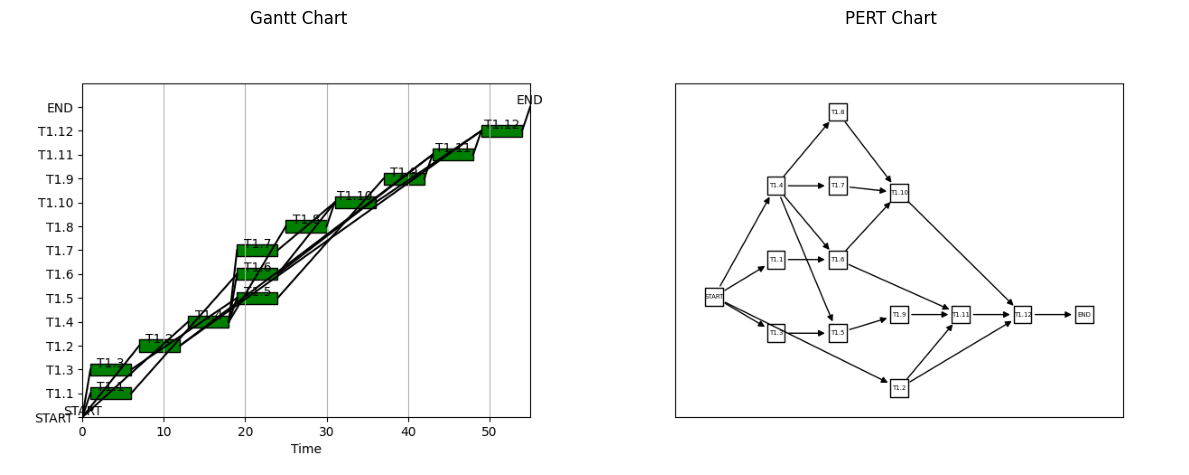

In [42]:
index = 11

output = schedule_graph.apply_assignment(assignment_list = best_list[index])
print(f"assigments: {best_list[index]}")
print(f"output: {output}")

schedule_graph.visualize()